In [1]:
import copy
import numpy as np
import os
import verdict

/home1/03057/zhafen/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import galaxy_dive.read_data.metafile as read_metafile
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.utilities as utilities
import galaxy_dive.utils.executable_helpers as exec_helpers

In [4]:
import linefinder.utils.file_management as file_management
import linefinder.analyze_data.worldline_set as worldline_set
import linefinder.analyze_data.worldlines as worldlines
import linefinder.utils.presentation_constants as p_constants
import linefinder.config as l_config

In [5]:
import analysis_config

# Load Data

In [6]:
do_calculation = True

In [7]:
snum, galdef = exec_helpers.choose_config_or_commandline(
    [ analysis_config.SNUM, analysis_config.GALDEF ]
)
print( 'Using snum {}, galdef {}'.format( snum, galdef ) )

Using snum 172, galdef _galdefv3


In [8]:
presentation_figure = False

In [9]:
mass_key = 'M'

In [10]:
save_file_tags = {
    'M' : 'mass',
    'metal_mass' : 'metalmass',
    'enriched_metal_mass' : 'enrichedmetalmass',
}

In [11]:
axes_labels = {
    'M' : 'Mass',
    'metal_mass' : 'Metal Mass',
    'enriched_metal_mass' : 'Metal Mass',
}

In [12]:
file_manager = file_management.FileManager( project='CGM_fate' )

In [13]:
ind = 600 - snum

In [14]:
tag_tail = '_CGM_snum{}'.format( snum )

In [15]:
defaults, variations = file_manager.get_linefinder_analysis_defaults_and_variations(
    tag_tail,
    sim_names = analysis_config.SIM_NAMES,
    galdef = galdef,
)
defaults, variations

({'ahf_index': 600,
  'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m12i_res7100/data',
  'halo_data_dir': '/scratch/03057/zhafen/core/m12i_res7100/halo',
  'ids_tag': 'm12i_CGM_snum172',
  'main_halo_id': 0,
  'ptracks_tag': 'm12i_CGM_snum172',
  'tag': 'm12i_CGM_snum172_galdefv3'},
 {'m10q': {'ahf_index': 600,
   'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m10q_res250/data',
   'halo_data_dir': '/scratch/03057/zhafen/core/m10q_res250/halo',
   'ids_tag': 'm10q_CGM_snum172',
   'main_halo_id': 0,
   'ptracks_tag': 'm10q_CGM_snum172',
   'tag': 'm10q_CGM_snum172_galdefv3'},
  'm10y': {'ahf_index': 600,
   'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m10y_res250/data',
   'halo_data_dir': '/scratch/03057/zhafen/core/m10y_res250/halo',
   'ids_tag': 'm10y_CGM_snum172',
   'main_halo_id': 0,
   'ptracks_tag': 'm10y_CGM_snum172',
   'tag': 'm10y_CGM_snum172_galdefv3'},
  'm10z': {'ahf_index': 600,
   'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m

In [16]:
w_set = worldline_set.WorldlineSet( defaults, variations )

In [17]:
default_sim_name = w_set.keys()[0]

In [18]:
w = w_set[default_sim_name]

In [19]:
classifications = copy.deepcopy( p_constants.CLASSIFICATIONS_CGM_FATE )
classifications.append( 'is_in_CGM' )

In [20]:
metafile_reader = read_metafile.MetafileReader(
    file_manager.get_metafile_dir( default_sim_name )
)

In [21]:
w_set['m12i'].classifications.parameters

Attribute classifications not found in plotting object. Checking data object.


{u'absolute_wind_cut': 15.0,
 u'classifications_to_save': array(['is_unaccreted', 'is_pristine', 'is_preprocessed', 'is_merger',
        'is_mass_transfer', 'is_wind', 'is_hitherto_EP', 'is_hitherto_NEP',
        'is_unaccreted_EP', 'is_unaccreted_NEP'], dtype='|S17'),
 u'events_to_save': array(['is_in_other_gal', 'is_in_main_gal', 'is_accreted', 'is_ejected',
        'redshift_first_acc', 'ind_first_acc',
        'cumulative_time_in_other_gal', 'gal_event_id',
        'time_in_other_gal_before_acc_during_interval'], dtype='|S44'),
 u'galids_tag': 'm12i_CGM_snum172_galdefv3',
 u'halo_data_dir': '/scratch/03057/zhafen/core/m12i_res7100/halo',
 u'halo_file_tag': 'smooth',
 u'main_halo_robustness_criteria': 'n_star',
 u'main_halo_robustness_value': 100,
 u'min_gal_density': 0.173,
 u'mtree_halos_index': 'None',
 u'neg': 10,
 u'not_in_main_gal_key': 'gal_id',
 u'out_dir': '/scratch/03057/zhafen/linefinder_data/core/m12i_res7100/data',
 u'pp_classifications_to_save': array(['is_in_CGM', 'is

# Analyze Data

### Get masses out

In [22]:
w_set.data_object.data_masker.clear_masks()

Dict, {
'm10q' : None,
'm11e_md' : None,
'm10z' : None,
'm11v' : None,
'm11q' : None,
'm10y' : None,
'm12r_md' : None,
'm12f' : None,
'm11i_md' : None,
'm11h_md' : None,
'm12m' : None,
'm11a' : None,
'm12i' : None,
'm11c' : None,
'm11b' : None,
'm12b_md' : None,
'm12z_md' : None,
'm12w_md' : None,
'm11d_md' : None,
'm12c_md' : None,
}

#### Mass Fractions

In [23]:
if do_calculation:
    
    CGM_mass_fractions = {}
    CGM_mass_fractions['and'] = {}

    # See what different fates consist of
    for classification in classifications:
        
        print( classification )

        # Sometimes we want to look at how things are relatively
        for joint, normalization_category in zip( [ False, True], [ classification, 'is_in_CGM' ] ):
            CGM_mass_fractions_cat = verdict.Dict( {} )
            for sim_name in w_set.keys():

                if classification == 'is_in_CGM':
                    inner_classifications = classifications
                else:
                    inner_classifications = p_constants.CLASSIFICATIONS_CGM_ORIGIN

                try:
                    CGM_mass_fractions_cat[sim_name] = w_set[sim_name].data_object.get_categories_selected_quantity_fraction(
                        normalization_category = normalization_category,
                        selection_routine = classification,
                        ptype = 'gas',
                        classification_list = inner_classifications,
                        sl = (slice(None),ind),
                        selected_quantity_data_key = mass_key,
                    )
                except ZeroDivisionError:
                    mass_fractions_sim = verdict.Dict( {} )
                    for inner_class in inner_classifications:
                        mass_fractions_sim[inner_class] = 0.0
                    CGM_mass_fractions_cat[sim_name] = mass_fractions_sim

            CGM_mass_fractions_cat = CGM_mass_fractions_cat.transpose()

            if joint:
                CGM_mass_fractions['and'][classification] = CGM_mass_fractions_cat
            else:
                CGM_mass_fractions[classification] = CGM_mass_fractions_cat
        
    # See where different origins go
    for classification in p_constants.CLASSIFICATIONS_CGM_ORIGIN:
        
        print( classification )

        CGM_mass_fractions_cat = verdict.Dict( {} )
        for sim_name in w_set.keys():
            
            inner_classifications = p_constants.CLASSIFICATIONS_CGM_FATE
            
            try:
                CGM_mass_fractions_cat[sim_name] = w_set[sim_name].data_object.get_categories_selected_quantity_fraction(
                    normalization_category = classification,
                    selection_routine = classification,
                    ptype = 'gas',
                    classification_list = inner_classifications,
                    sl = (slice(None),ind),
                    selected_quantity_data_key = mass_key,
                )
            except ZeroDivisionError:
                mass_fractions_sim = verdict.Dict( {} )
                for inner_class in inner_classifications:
                    mass_fractions_sim[inner_class] = 0.0
                CGM_mass_fractions_cat[sim_name] = mass_fractions_sim

        CGM_mass_fractions_cat = CGM_mass_fractions_cat.transpose()

        CGM_mass_fractions[classification] = CGM_mass_fractions_cat

    CGM_mass_fractions = verdict.Dict( CGM_mass_fractions )

is_CGM_to_IGM
is_CGM_to_gal_or_interface
is_hereafter_CGM
is_in_CGM
is_CGM_IGM_accretion
is_CGM_wind
is_CGM_satellite_wind
is_CGM_satellite_ISM


#### Halo Masses

In [24]:
w_set.data_object.halo_data.get_mt_data( 'Mvir', snums=[ snum ], )

Dict, {
'm10q' : array([2.59999e+09]),
'm11e_md' : array([2.29681e+10]),
'm10z' : array([9.21258e+09]),
'm11v' : array([3.78509e+10]),
'm11q' : array([3.03953e+10]),
'm10y' : array([2.24179e+09]),
'm12r_md' : array([1.20623e+11]),
'm12f' : array([3.39571e+11]),
'm11i_md' : array([1.39435e+10]),
'm11h_md' : array([6.09945e+10]),
'm12m' : array([3.82052e+11]),
'm11a' : array([7.38578e+09]),
'm12i' : array([2.0516e+11]),
'm11c' : array([3.29675e+10]),
'm11b' : array([1.07873e+10]),
'm12b_md' : array([3.21527e+11]),
'm12z_md' : array([8.04373e+10]),
'm12w_md' : array([1.56338e+11]),
'm11d_md' : array([2.96814e+10]),
'm12c_md' : array([1.00317e+11]),
}

In [25]:
if do_calculation:
    w_set.data_object.retrieve_halo_data()
    halo_masses = w_set.m_vir.inner_item( snum )

Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Ch

#### Save and load results

In [26]:
savefile = os.path.join(
    file_manager.project_parameters['output_data_dir'],
    'cgm_fates_{}_frac_snum{}.hdf5'.format( save_file_tags[mass_key], snum ),
)

In [27]:
if do_calculation:

    # Format results to save
    results_to_save = copy.deepcopy( CGM_mass_fractions )
    results_to_save['m_vir'] = halo_masses

    results_to_save.to_hdf5(
        savefile, 
        condensed = True, 
        attributes = { 'redshift': w.redshift.values[ind] },
    )
    
    redshift = w.redshift.values[ind]

Attribute redshift not found in plotting object. Checking data object.
Attribute redshift not found in plotting object. Checking data object.


In [28]:
if not do_calculation:
    results_to_load, attributes = verdict.Dict.from_hdf5( savefile, unpack=True )
    
    halo_masses = results_to_load['m_vir']
    CGM_mass_fractions = copy.deepcopy( results_to_load )
    del CGM_mass_fractions['m_vir']
    
    redshift = attributes['redshift']

# Plot Data

## Setup

In [29]:
mass_range = [ halo_masses.array().min()/1.5, halo_masses.array().max()*1.5 ]
mass_range

[2128955365.6220324, 816350427350.4275]

In [30]:
m_vir_md_split = halo_masses.split_by_key_slice( slice(4,10), '_md' )
m_vir_fiducials = m_vir_md_split[False]
m_vir_mds = m_vir_md_split[True]

In [31]:
def save_plot_stage( fig, base_save_file, index ):

    save_file = '{}.{}.pdf'.format( base_save_file, index )
    
    plotting.save_fig(
        out_dir = file_manager.get_project_presentation_dir(),
        save_file = save_file,
        fig = fig,
    )
    
    return index + 1

## Mass Fraction Plot

In [32]:
CGM_mass_fractions['is_CGM_to_IGM']

Dict, {
'is_CGM_satellite_wind' : Dict, {
'm10q' : 0.028254304,
'm11e_md' : 0.098379835,
'm10z' : 0.07029502,
'm11v' : 0.09999997,
'm11q' : 0.03163728,
'm10y' : 0.032171488,
'm12r_md' : 0.026705572,
'm12f' : 0.13184537,
'm11i_md' : 0.011286215,
'm11h_md' : 0.120961346,
'm12m' : 0.40539727,
'm11a' : 0.0026789552,
'm12i' : 0.24997269,
'm11c' : 0.1235444,
'm11b' : 0.003495801,
'm12b_md' : 0.29446626,
'm12z_md' : 0.22805934,
'm12w_md' : 0.1875056,
'm11d_md' : 0.04477339,
'm12c_md' : 0.042084463,
}
,
'is_CGM_wind' : Dict, {
'm10q' : 0.3877474,
'm11e_md' : 0.33781925,
'm10z' : 0.43526512,
'm11v' : 0.49159276,
'm11q' : 0.5846521,
'm10y' : 0.2660796,
'm12r_md' : 0.62540126,
'm12f' : 0.40866274,
'm11i_md' : 0.45089677,
'm11h_md' : 0.35696614,
'm12m' : 0.16919936,
'm11a' : 0.36930507,
'm12i' : 0.36431128,
'm11c' : 0.22159958,
'm11b' : 0.4983825,
'm12b_md' : 0.3899632,
'm12z_md' : 0.30268556,
'm12w_md' : 0.223125,
'm11d_md' : 0.43596625,
'm12c_md' : 0.49117583,
}
,
'is_CGM_satellite_ISM' : Dict, 

File saved at /home1/03057/zhafen/papers/CGM_fate/figures/CGM_mass_frac_vs_Mh_CGM_snum172.pdf


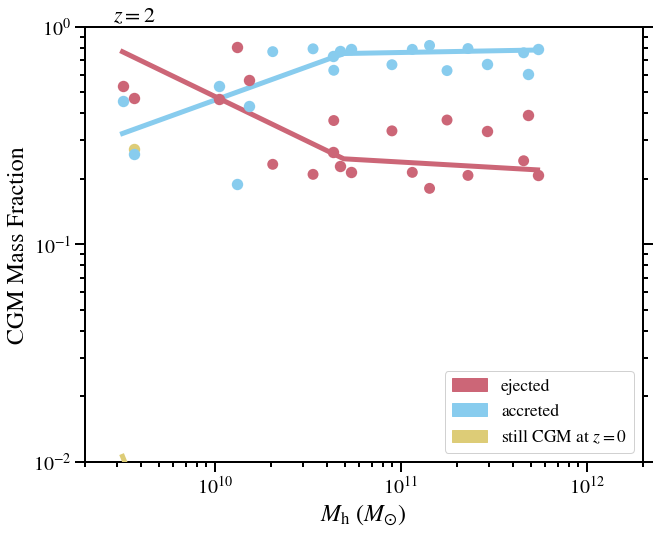

In [33]:
fig = plt.figure( figsize=(10,8), facecolor='w' )
ax = plt.gca()

# Some plot settings
y_min = 1e-2
y_max = 1
alpha = 1.0

# Plot data points
color_objects = []
labels = []
j = 0
for k, classification in enumerate( p_constants.CLASSIFICATIONS_CGM_FATE ):
    
    if presentation_figure:
                
        j = save_plot_stage( fig, 'CGM_{}_frac_vs_Mh{}'.format( save_file_tags[mass_key], tag_tail ), j )
    
    if classification == 'is_in_CGM':
        continue
        
    item = CGM_mass_fractions['is_in_CGM'][classification]
    
    md_split = item.split_by_key_slice( slice(4,10), '_md' )
    fiducials = md_split[False]
    mds = md_split[True]
    
    edgecolor = np.array( matplotlib.colors.colorConverter.to_rgba(
        l_config.COLORSCHEME[classification]
    ) )
    edgecolor[-1] = alpha
        
    # Default points
    ax.scatter(
        m_vir_fiducials.array(),
        fiducials.array(),
        s = 130,
        color = None,
        zorder = 100 - k,
        linewidth = 0,
        facecolors = l_config.COLORSCHEME[classification],
        alpha = alpha,
    )
    
    if mass_key != 'M':
        facecolors = 'none'
        color = edgecolor
    else:
        facecolors = l_config.COLORSCHEME[classification]
        color = 'none'
        
    # Turbulent metal diffusion
    ax.scatter(
        m_vir_mds.array(),
        mds.array(),
        s = 120,
        color = color,
        marker = 'o',
        zorder = 100 - k,
        facecolors = facecolors,
        linewidth = 3.5,
        alpha = alpha,
    )
    
    # Box plot
    if mass_key != 'M':
        x_data_list = [ m_vir_fiducials, m_vir_mds, ]
        y_data_list = [ fiducials, mds, ]
        linestyles = [ '-', '--', ]
    else:
        x_data_list = [ halo_masses, ]
        y_data_list = [ item, ]
        linestyles = [ '-', ]
    for x_data, y_data, linestyle in zip( x_data_list, y_data_list, linestyles ):
        x_datas = x_data.split_by_dict( l_config.MASS_BINS, return_list=True )
        y_datas = y_data.split_by_dict( l_config.MASS_BINS, return_list=True )
        plotting.box_plot(
            x_datas,
            y_datas,
            ax = ax,
            color = l_config.COLORSCHEME[classification],
            box_zorder = 50 - k,
            blank_zorder = 30 - k,
            line_zorder = 10 - k,
    #         linewidth = 7 - k,
            linewidth = 5,
            linestyle = linestyle,
            y_floor = 1e-5,
            plot_boxes = False,
            line_x_min = x_data.array().min(),
            line_x_max = x_data.array().max(),
            y_mean_statistic = np.median,
        )
    
    if classification is not None:
        # Make virtual artists to allow a legend to appear
        color_object = matplotlib.patches.Rectangle(                         
            (0, 0),                                                          
            1,                                                               
            1,                                                               
            fc = l_config.COLORSCHEME[classification],                                 
            ec = l_config.COLORSCHEME[classification],                                 
            alpha = p_constants.CLASSIFICATION_ALPHA,                        
        )
        color_objects.append( color_object )                                 
        labels.append( p_constants.CLASSIFICATION_LABELS[classification] )

    # Add a redshift label
    if k == 0:
        redshift_label = r'$z=' + '{:.02g}'.format( redshift ) + '$'
        ax.annotate( s=redshift_label, xy=(0.05,1.0125), xycoords='axes fraction', fontsize=22 )

    if snum == 172:
        ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=24 )
    ax.set_ylabel( r'CGM {} Fraction'.format( axes_labels[mass_key] ), fontsize=24 )

    ax.set_xlim( 2e9, 2e12 )
    ax.set_ylim( y_min, y_max )

    ax.set_xscale( 'log' )
    ax.set_yscale( 'log' )
    
    # Add ticks to the righ
    ax.yaxis.set_ticks_position( 'both' )

    if snum == 172:
        legend = ax.legend(
            color_objects,
            labels,
            prop={'size': 17.5},
            ncol=1,
            loc='lower right',
            fontsize=24,
            framealpha = 0.9,
        )
        legend.set_zorder( 120 )

save_file = 'CGM_{}_frac_vs_Mh{}.pdf'.format( save_file_tags[mass_key], tag_tail )

plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

# Connection Between Origin and Fate

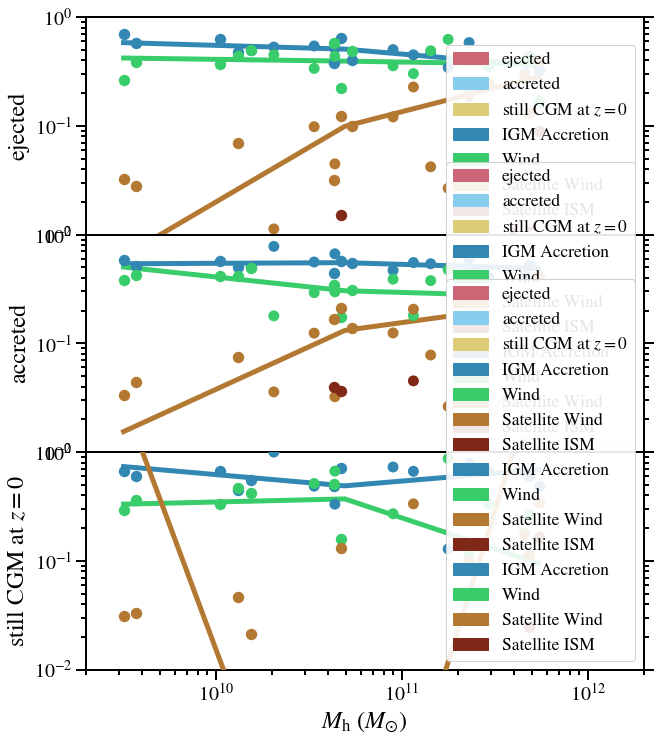

In [34]:
outer_classifications = p_constants.CLASSIFICATIONS_CGM_FATE
inner_classifications = p_constants.CLASSIFICATIONS_CGM_ORIGIN

n_rows = len( outer_classifications )

fig = plt.figure( figsize=(10,n_rows*4), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1, )
gs.update( hspace=0.00001 )

for i, outer_classification in enumerate( outer_classifications ):
    
    ax = plt.subplot( gs[i,0] )
    
    for j, classification in enumerate( inner_classifications ):
        
        item = CGM_mass_fractions[outer_classification][classification]

        md_split = item.split_by_key_slice( slice(4,10), '_md' )
        fiducials = md_split[False]
        mds = md_split[True]

        edgecolor = np.array( matplotlib.colors.colorConverter.to_rgba(
            l_config.COLORSCHEME[classification]
        ) )
        edgecolor[-1] = alpha

        # Default points
        ax.scatter(
            m_vir_fiducials.array(),
            fiducials.array(),
            s = 130,
            color = None,
            zorder = 100 - k,
            linewidth = 0,
            facecolors = l_config.COLORSCHEME[classification],
            alpha = alpha,
        )

        if mass_key != 'M':
            facecolors = 'none'
            color = edgecolor
        else:
            facecolors = l_config.COLORSCHEME[classification]
            color = 'none'

        # Turbulent metal diffusion
        ax.scatter(
            m_vir_mds.array(),
            mds.array(),
            s = 120,
            color = color,
            marker = 'o',
            zorder = 100 - k,
            facecolors = facecolors,
            linewidth = 3.5,
            alpha = alpha,
        )

        # Box plot
        if mass_key != 'M':
            x_data_list = [ m_vir_fiducials, m_vir_mds, ]
            y_data_list = [ fiducials, mds, ]
            linestyles = [ '-', '--', ]
        else:
            x_data_list = [ halo_masses, ]
            y_data_list = [ item, ]
            linestyles = [ '-', ]
        for x_data, y_data, linestyle in zip( x_data_list, y_data_list, linestyles ):
            x_datas = x_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            y_datas = y_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            plotting.box_plot(
                x_datas,
                y_datas,
                ax = ax,
                color = l_config.COLORSCHEME[classification],
                box_zorder = 50 - k,
                blank_zorder = 30 - k,
                line_zorder = 10 - k,
        #         linewidth = 7 - k,
                linewidth = 5,
                linestyle = linestyle,
                y_floor = 1e-5,
                plot_boxes = False,
                line_x_min = x_data.array().min(),
                line_x_max = x_data.array().max(),
                y_mean_statistic = np.median,
            )

        if classification is not None:
            # Make virtual artists to allow a legend to appear
            color_object = matplotlib.patches.Rectangle(                         
                (0, 0),                                                          
                1,                                                               
                1,                                                               
                fc = l_config.COLORSCHEME[classification],                                 
                ec = l_config.COLORSCHEME[classification],                                 
                alpha = p_constants.CLASSIFICATION_ALPHA,                        
            )
            color_objects.append( color_object )                                 
            labels.append( p_constants.CLASSIFICATION_LABELS[classification] )

        # Add a redshift label
        if k == 0:
            redshift_label = r'$z=' + '{:.02g}'.format( redshift ) + '$'
            ax.annotate( s=redshift_label, xy=(0.05,1.0125), xycoords='axes fraction', fontsize=22 )

        if snum == 172:
            ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=24 )
        ax.set_ylabel( p_constants.CLASSIFICATION_LABELS[outer_classification], fontsize=24 )

        ax.set_xlim( 2e9, 2e12 )
        ax.set_ylim( y_min, y_max )

        ax.set_xscale( 'log' )
        ax.set_yscale( 'log' )

        # Add ticks to the right
        ax.yaxis.set_ticks_position( 'both' )

        if snum == 172:
            legend = ax.legend(
                color_objects,
                labels,
                prop={'size': 17.5},
                ncol=1,
                loc='lower right',
                fontsize=24,
                framealpha = 0.9,
            )
            legend.set_zorder( 120 )

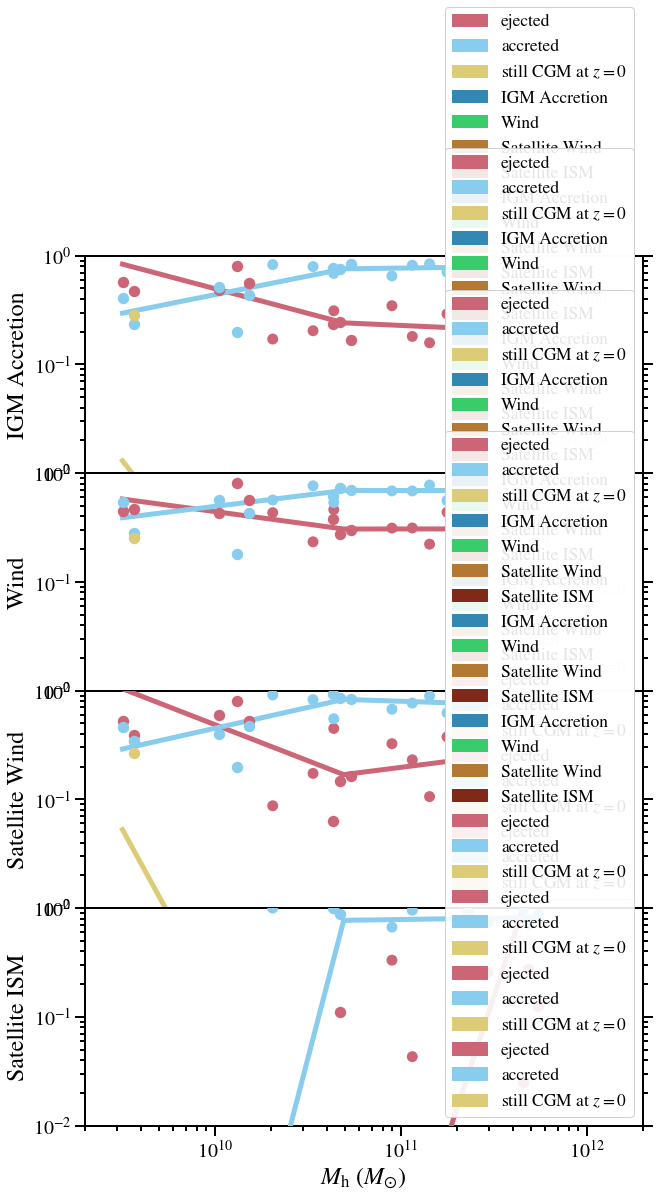

In [35]:
inner_classifications = p_constants.CLASSIFICATIONS_CGM_FATE
outer_classifications = p_constants.CLASSIFICATIONS_CGM_ORIGIN

n_rows = len( outer_classifications )

fig = plt.figure( figsize=(10,n_rows*4), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1, )
gs.update( hspace=0.00001 )

for i, outer_classification in enumerate( outer_classifications ):
    
    ax = plt.subplot( gs[i,0] )
    
    for j, classification in enumerate( inner_classifications ):
        
        item = CGM_mass_fractions[outer_classification][classification]

        md_split = item.split_by_key_slice( slice(4,10), '_md' )
        fiducials = md_split[False]
        mds = md_split[True]

        edgecolor = np.array( matplotlib.colors.colorConverter.to_rgba(
            l_config.COLORSCHEME[classification]
        ) )
        edgecolor[-1] = alpha

        # Default points
        ax.scatter(
            m_vir_fiducials.array(),
            fiducials.array(),
            s = 130,
            color = None,
            zorder = 100 - k,
            linewidth = 0,
            facecolors = l_config.COLORSCHEME[classification],
            alpha = alpha,
        )

        if mass_key != 'M':
            facecolors = 'none'
            color = edgecolor
        else:
            facecolors = l_config.COLORSCHEME[classification]
            color = 'none'

        # Turbulent metal diffusion
        ax.scatter(
            m_vir_mds.array(),
            mds.array(),
            s = 120,
            color = color,
            marker = 'o',
            zorder = 100 - k,
            facecolors = facecolors,
            linewidth = 3.5,
            alpha = alpha,
        )

        # Box plot
        if mass_key != 'M':
            x_data_list = [ m_vir_fiducials, m_vir_mds, ]
            y_data_list = [ fiducials, mds, ]
            linestyles = [ '-', '--', ]
        else:
            x_data_list = [ halo_masses, ]
            y_data_list = [ item, ]
            linestyles = [ '-', ]
        for x_data, y_data, linestyle in zip( x_data_list, y_data_list, linestyles ):
            x_datas = x_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            y_datas = y_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            plotting.box_plot(
                x_datas,
                y_datas,
                ax = ax,
                color = l_config.COLORSCHEME[classification],
                box_zorder = 50 - k,
                blank_zorder = 30 - k,
                line_zorder = 10 - k,
        #         linewidth = 7 - k,
                linewidth = 5,
                linestyle = linestyle,
                y_floor = 1e-5,
                plot_boxes = False,
                line_x_min = x_data.array().min(),
                line_x_max = x_data.array().max(),
                y_mean_statistic = np.median,
            )

        if classification is not None:
            # Make virtual artists to allow a legend to appear
            color_object = matplotlib.patches.Rectangle(                         
                (0, 0),                                                          
                1,                                                               
                1,                                                               
                fc = l_config.COLORSCHEME[classification],                                 
                ec = l_config.COLORSCHEME[classification],                                 
                alpha = p_constants.CLASSIFICATION_ALPHA,                        
            )
            color_objects.append( color_object )                                 
            labels.append( p_constants.CLASSIFICATION_LABELS[classification] )

        # Add a redshift label
        if k == 0:
            redshift_label = r'$z=' + '{:.02g}'.format( redshift ) + '$'
            ax.annotate( s=redshift_label, xy=(0.05,1.0125), xycoords='axes fraction', fontsize=22 )

        if snum == 172:
            ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=24 )
        ax.set_ylabel( p_constants.CLASSIFICATION_LABELS[outer_classification], fontsize=24 )

        ax.set_xlim( 2e9, 2e12 )
        ax.set_ylim( y_min, y_max )

        ax.set_xscale( 'log' )
        ax.set_yscale( 'log' )

        # Add ticks to the right
        ax.yaxis.set_ticks_position( 'both' )

        if snum == 172:
            legend = ax.legend(
                color_objects,
                labels,
                prop={'size': 17.5},
                ncol=1,
                loc='lower right',
                fontsize=24,
                framealpha = 0.9,
            )
            legend.set_zorder( 120 )

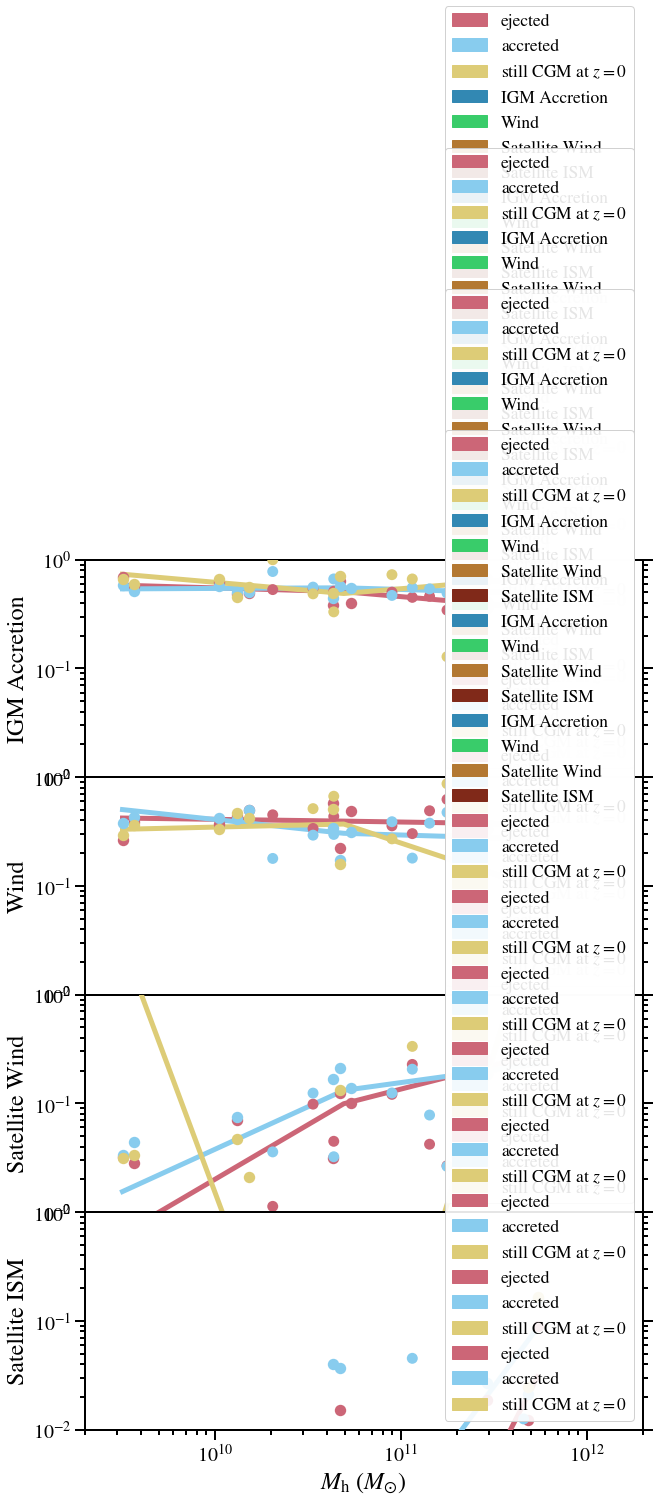

In [36]:
inner_classifications = p_constants.CLASSIFICATIONS_CGM_FATE
outer_classifications = p_constants.CLASSIFICATIONS_CGM_ORIGIN

n_rows = len( outer_classifications )

fig = plt.figure( figsize=(10,n_rows*4), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1, )
gs.update( hspace=0.00001 )

for i, outer_classification in enumerate( outer_classifications ):
    
    ax = plt.subplot( gs[i,0] )
    
    for j, classification in enumerate( inner_classifications ):
        
        item = CGM_mass_fractions['and'][classification][outer_classification]

        md_split = item.split_by_key_slice( slice(4,10), '_md' )
        fiducials = md_split[False]
        mds = md_split[True]

        edgecolor = np.array( matplotlib.colors.colorConverter.to_rgba(
            l_config.COLORSCHEME[classification]
        ) )
        edgecolor[-1] = alpha

        # Default points
        ax.scatter(
            m_vir_fiducials.array(),
            fiducials.array(),
            s = 130,
            color = None,
            zorder = 100 - k,
            linewidth = 0,
            facecolors = l_config.COLORSCHEME[classification],
            alpha = alpha,
        )

        if mass_key != 'M':
            facecolors = 'none'
            color = edgecolor
        else:
            facecolors = l_config.COLORSCHEME[classification]
            color = 'none'

        # Turbulent metal diffusion
        ax.scatter(
            m_vir_mds.array(),
            mds.array(),
            s = 120,
            color = color,
            marker = 'o',
            zorder = 100 - k,
            facecolors = facecolors,
            linewidth = 3.5,
            alpha = alpha,
        )

        # Box plot
        if mass_key != 'M':
            x_data_list = [ m_vir_fiducials, m_vir_mds, ]
            y_data_list = [ fiducials, mds, ]
            linestyles = [ '-', '--', ]
        else:
            x_data_list = [ halo_masses, ]
            y_data_list = [ item, ]
            linestyles = [ '-', ]
        for x_data, y_data, linestyle in zip( x_data_list, y_data_list, linestyles ):
            x_datas = x_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            y_datas = y_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            plotting.box_plot(
                x_datas,
                y_datas,
                ax = ax,
                color = l_config.COLORSCHEME[classification],
                box_zorder = 50 - k,
                blank_zorder = 30 - k,
                line_zorder = 10 - k,
        #         linewidth = 7 - k,
                linewidth = 5,
                linestyle = linestyle,
                y_floor = 1e-5,
                plot_boxes = False,
                line_x_min = x_data.array().min(),
                line_x_max = x_data.array().max(),
                y_mean_statistic = np.median,
            )

        if classification is not None:
            # Make virtual artists to allow a legend to appear
            color_object = matplotlib.patches.Rectangle(                         
                (0, 0),                                                          
                1,                                                               
                1,                                                               
                fc = l_config.COLORSCHEME[classification],                                 
                ec = l_config.COLORSCHEME[classification],                                 
                alpha = p_constants.CLASSIFICATION_ALPHA,                        
            )
            color_objects.append( color_object )                                 
            labels.append( p_constants.CLASSIFICATION_LABELS[classification] )

        # Add a redshift label
        if k == 0:
            redshift_label = r'$z=' + '{:.02g}'.format( redshift ) + '$'
            ax.annotate( s=redshift_label, xy=(0.05,1.0125), xycoords='axes fraction', fontsize=22 )

        if snum == 172:
            ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=24 )
        ax.set_ylabel( p_constants.CLASSIFICATION_LABELS[outer_classification], fontsize=24 )

        ax.set_xlim( 2e9, 2e12 )
        ax.set_ylim( y_min, y_max )

        ax.set_xscale( 'log' )
        ax.set_yscale( 'log' )

        # Add ticks to the right
        ax.yaxis.set_ticks_position( 'both' )

        if snum == 172:
            legend = ax.legend(
                color_objects,
                labels,
                prop={'size': 17.5},
                ncol=1,
                loc='lower right',
                fontsize=24,
                framealpha = 0.9,
            )
            legend.set_zorder( 120 )

# Check if the above is correct

# Detailed Analysis

In [37]:
import os

import py2tex.py2tex as py2tex

In [38]:
tex_filepath = os.path.join( file_manager.project_parameters['project_dir'], 'variables.tex' )

In [39]:
tex_file = py2tex.TeXVariableFile( tex_filepath )

In [40]:
# Used for variable names
if snum == 465:
    regime = 'low'
if snum == 172:
    regime = 'high'